In [ ]:
# Importing the necessary libraries and modules
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras import backend as K
import matplotlib.pyplot as plt
from keras.regularizers import l2
import plotly.graph_objects as go
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# Loading the dataset
df = pd.read_csv('MSFT.csv', parse_dates = ['Date'])

In [ ]:
# Displaying the first few rows of the dataset
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.060055,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.062199,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.063272,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.061663,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.060591,47894400


In [ ]:
# Checking the shape of the dataset
df.shape

(9628, 7)

In [ ]:
# Quick overview of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9628 entries, 0 to 9627
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       9628 non-null   datetime64[ns]
 1   Open       9628 non-null   float64       
 2   High       9628 non-null   float64       
 3   Low        9628 non-null   float64       
 4   Close      9628 non-null   float64       
 5   Adj Close  9628 non-null   float64       
 6   Volume     9628 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 526.7 KB


In [ ]:
# Displaying the column names
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [ ]:
# Checking for null values
print(df.isnull().sum())

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [ ]:
# Create the candlestick chart
figure = go.Figure(data=[go.Candlestick(x=df["Date"],
                                        open=df["Open"],
                                        high=df["High"],
                                        low=df["Low"],
                                        close=df["Close"])])

# Update the layout with more descriptive details
figure.update_layout(
    title="Stock Price Analysis",
    xaxis_title="Date",
    yaxis_title="Stock Price (USD)",
    xaxis_rangeslider_visible=False,
    template="plotly_dark"  # Optional: dark theme for better aesthetics
)

# Show the figure
figure.show()

In [ ]:
# Separate numeric columns
numeric_cols = df.select_dtypes(include=['number']).columns
df_numeric = df[numeric_cols]

# Standardize numeric data
df = (df_numeric - df_numeric.mean()) / df_numeric.std()

# Recombine the DataFrame
df[numeric_cols] = df

print(df)

          Open      High       Low     Close  Adj Close     Volume
0    -0.653727 -0.654184 -0.653283 -0.653636  -0.589224  25.559033
1    -0.653626 -0.654174 -0.653182 -0.653595  -0.589200   6.586441
2    -0.653586 -0.654164 -0.653141 -0.653575  -0.589187   1.998466
3    -0.653566 -0.654164 -0.653161 -0.653606  -0.589206   0.283638
4    -0.653596 -0.654194 -0.653182 -0.653626  -0.589218  -0.237379
...        ...       ...       ...       ...        ...        ...
9623  4.201487  4.230471  4.248248  4.259571   4.326039  -1.066474
9624  4.277992  4.301451  4.304979  4.302320   4.368803  -0.930630
9625  4.315667  4.295040  4.331594  4.319420   4.385908  -1.019239
9626  4.348950  4.308664  4.311633  4.278750   4.345225  -1.041839
9627  4.282153  4.279585  4.299843  4.315261   4.381747  -1.182526

[9628 rows x 6 columns]


In [ ]:
# Drop the "Date" column before calculating correlations
correlation = df.corr()

# Print the correlation with the "Close" column
print("Correlation with 'Close' column:")
print(correlation["Close"].sort_values(ascending=False))

Correlation with 'Close' column:
Close        1.000000
Low          0.999941
High         0.999933
Open         0.999867
Adj Close    0.998878
Volume      -0.341419
Name: Close, dtype: float64


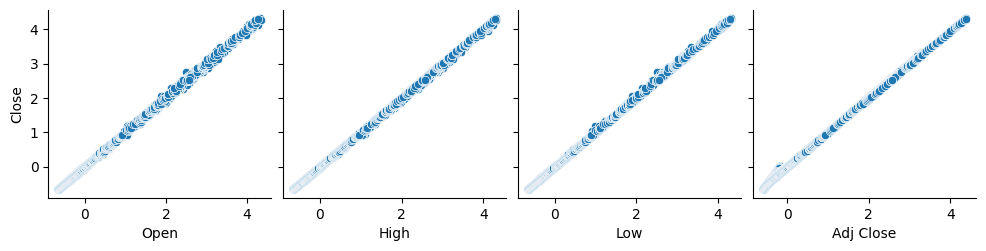

In [ ]:
# show the correlation between features and label
correlation = sns.pairplot(data=df, x_vars=['Open', 'High', 'Low','Adj Close'], y_vars=['Close'])


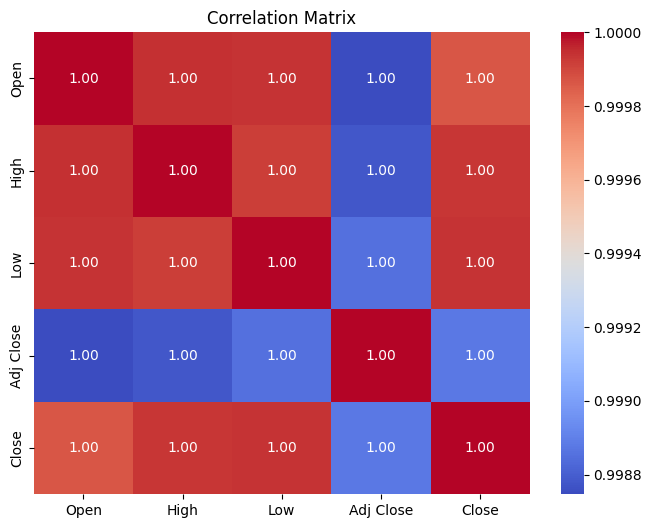

In [ ]:
# Compute the correlation matrix
correlation_matrix = df[['Open', 'High', 'Low', 'Adj Close', 'Close']].corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
plt.title('Correlation Matrix')
plt.show()

In [ ]:
# Selecting Features and Target Variable
x = df[["Open", "High", "Low", "Volume"]]  # Features
y = df["Close"]  # Target variable

# Convert DataFrame to NumPy arrays
x = x.to_numpy()
y = y.to_numpy()
y = y.reshape(-1, 1)  # Reshape y to match model input shape

# Splitting Data into Training and Testing Sets
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.15, random_state=42)

In [ ]:
# printing out the shapes of the training and testing datasets
print("Training set shapes:")
print("Features (xtrain):", xtrain.shape)
print("Target variable (ytrain):", ytrain.shape)

print("\nTesting set shapes:")
print("Features (xtest):", xtest.shape)
print("Target variable (ytest):", ytest.shape)

Training set shapes:
Features (xtrain): (8183, 4)
Target variable (ytrain): (8183, 1)

Testing set shapes:
Features (xtest): (1445, 4)
Target variable (ytest): (1445, 1)


In [ ]:
# Model Initialization
model = Sequential()

# Adding LSTM layers
model.add(LSTM(128, return_sequences=True, input_shape=(xtrain.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=True, input_shape=(xtrain.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(32, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(16, return_sequences=False))
model.add(Dropout(0.2))

# Adding Dense layers with Ridge regularization
model.add(Dense(25, kernel_regularizer=l2(0.01)))  # Ridge regularization with lambda = 0.01
model.add(Dense(1))  # Output layer

# Model Summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_13 (LSTM)              (None, 4, 128)            66560     
                                                                 
 dropout_13 (Dropout)        (None, 4, 128)            0         
                                                                 
 lstm_14 (LSTM)              (None, 4, 64)             49408     
                                                                 
 dropout_14 (Dropout)        (None, 4, 64)             0         
                                                                 
 lstm_15 (LSTM)              (None, 4, 32)             12416     
                                                                 
 dropout_15 (Dropout)        (None, 4, 32)             0         
                                                                 
 lstm_16 (LSTM)              (None, 16)               

In [ ]:
# Function R2 is designed to calculate the coefficient of determination (R-squared)

def R2(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - ss_res / (ss_tot + K.epsilon())

In [ ]:
# Adding EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Adding ModelCheckpoint callback
model_checkpoint = ModelCheckpoint('Stock_Prices_Prediction.h5', monitor='val_loss', save_best_only=True)

# Define the learning rate
learning_rate = 0.001

# Compile the model
# Compile the model with a specific learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', R2])

# Train the model
history = model.fit(xtrain, ytrain,
          batch_size=32,
          epochs=100,
          validation_split=0.15,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/100
218/218 [==============================] - 16s 29ms/step - loss: 0.2812 - mse: 0.1378 - R2: 0.8545 - val_loss: 0.1058 - val_mse: 0.0064 - val_R2: 0.9917
Epoch 2/100
  7/218 [..............................] - ETA: 4s - loss: 0.1343 - mse: 0.0355 - R2: 0.9597

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



218/218 [==============================] - 6s 26ms/step - loss: 0.0978 - mse: 0.0260 - R2: 0.9714 - val_loss: 0.0515 - val_mse: 0.0021 - val_R2: 0.9972
Epoch 3/100
218/218 [==============================] - 5s 22ms/step - loss: 0.0609 - mse: 0.0248 - R2: 0.9727 - val_loss: 0.0323 - val_mse: 0.0064 - val_R2: 0.9929
Epoch 4/100
218/218 [==============================] - 5s 23ms/step - loss: 0.0462 - mse: 0.0263 - R2: 0.9721 - val_loss: 0.0205 - val_mse: 0.0053 - val_R2: 0.9940
Epoch 5/100
218/218 [==============================] - 6s 27ms/step - loss: 0.0343 - mse: 0.0217 - R2: 0.9770 - val_loss: 0.0149 - val_mse: 0.0047 - val_R2: 0.9948
Epoch 6/100
218/218 [==============================] - 4s 20ms/step - loss: 0.0337 - mse: 0.0252 - R2: 0.9724 - val_loss: 0.0092 - val_mse: 0.0022 - val_R2: 0.9974
Epoch 7/100
218/218 [==============================] - 4s 20ms/step - loss: 0.0290 - mse: 0.0227 - R2: 0.9740 - val_loss: 0.0227 - val_mse: 0.0174 - val_R2: 0.9810
Epoch 8/100
218/218 [=======

In [ ]:
# Saving the model
model.save('Stock_Prices_Prediction.keras')

In [ ]:
# Evaluate the model on the test data
test_loss = model.evaluate(xtest, ytest)

# Print the test loss
print(f'Test Loss: {test_loss}')

46/46 [==============================] - 0s 7ms/step - loss: 0.0035 - mse: 0.0013 - R2: 0.9986
Test Loss: [0.0034504688810557127, 0.001320274779573083, 0.9986368417739868]


In [ ]:
# preview y test
print(ytest)

# Make predictions
ypred = model.predict(xtest)

# Print predictions
print("Predictions:")
print(ypred)

[[ 2.58622166]
 [ 0.0933552 ]
 [-0.34245736]
 ...
 [-0.27798667]
 [-0.30872001]
 [-0.2798353 ]]
46/46 [==============================] - 0s 6ms/step
Predictions:
[[ 2.6094248 ]
 [ 0.11959235]
 [-0.3410217 ]
 ...
 [-0.2848031 ]
 [-0.31130388]
 [-0.27562055]]


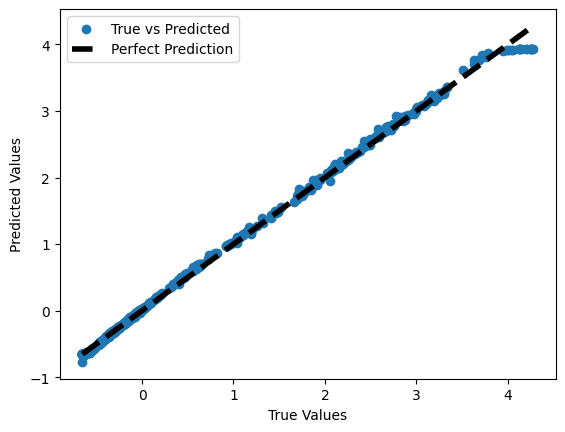

In [ ]:
# Plot predictions vs true values
fig, ax = plt.subplots()
ax.scatter(ytest, ypred, label='True vs Predicted')
ax.plot([ytest.min(), ytest.max()], [ytest.min(), ytest.max()], 'k--', lw=4, label='Perfect Prediction')
ax.set_xlabel('True Values')
ax.set_ylabel('Predicted Values')
plt.legend()
plt.show()

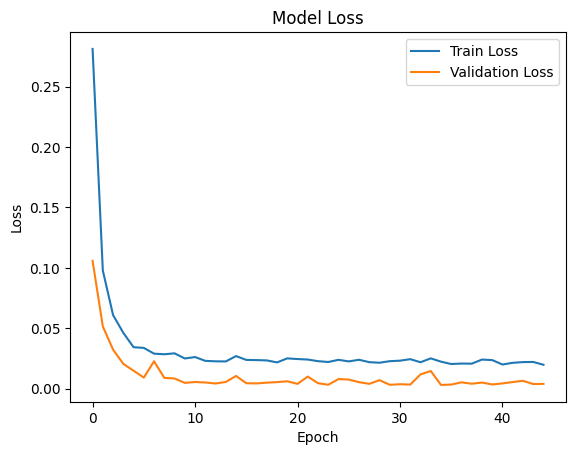

In [ ]:
# Plot training & validation loss values
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()